In [87]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [88]:
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        return F.softmax(output, dim=-1)

In [89]:
class Critic(nn.Module):
    def __init__(self, state_size: int):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        return self.linear3(output)

In [90]:
class A2C:
    def __init__(self, env: gym.Env,num_episodes: int = 1000, alpha_actor: float = 0.001, alpha_critic: float = 0.001, gamma: float = 0.99, render: bool = False) -> None:
        self.env: gym.Env = env
        self.num_episodes: int = num_episodes
        self.gamma: float = gamma
        self.render: bool = render

        self.actor: Actor = Actor(2, 3)
        self.critic: Critic = Critic(2)
        self.actor_optimizer: optim.SGD = optim.SGD(self.actor.parameters(), lr=alpha_actor)
        self.critic_optimizer: optim.SGD = optim.SGD(self.critic.parameters(), lr=alpha_critic)

    def train(self) -> tuple[list[int]]:
        lives = []
        rewards = []
        for _ in range(self.num_episodes):
            state = torch.from_numpy(self.env.reset()[0])
            done = False
            decay = 1
            life = 0
            total_reward = 0
            while not done:
                actions = self.actor.forward(state)
                m = distributions.Categorical(actions)
                action = m.sample()
                log_prob = m.log_prob(action)
                next_state, reward, terminated, truncated, _ = self.env.step(action.numpy())
                next_state = torch.from_numpy(next_state)

                state_val = self.critic.forward(state)
                next_state_val = self.critic.forward(next_state)

                critic_loss = decay * F.mse_loss(reward + self.gamma * next_state_val, state_val)

                policy_loss = -log_prob * decay * (reward + self.gamma * next_state_val.item() - state_val.item())

                self.critic_optimizer.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.critic_optimizer.step()

                self.actor_optimizer.zero_grad()
                policy_loss.backward()
                self.actor_optimizer.step()

                decay *= self.gamma
                state = next_state
                done = terminated or truncated
                life += 1
                total_reward += reward
                if self.render:
                    self.env.render()
            lives.append(life)
            rewards.append(total_reward)

        return lives, rewards

In [91]:
env = gym.make("MountainCar-v0")
agent = A2C(env)
info = agent.train()

Text(0, 0.5, 'Lifespan (# steps)/Episode Reward')

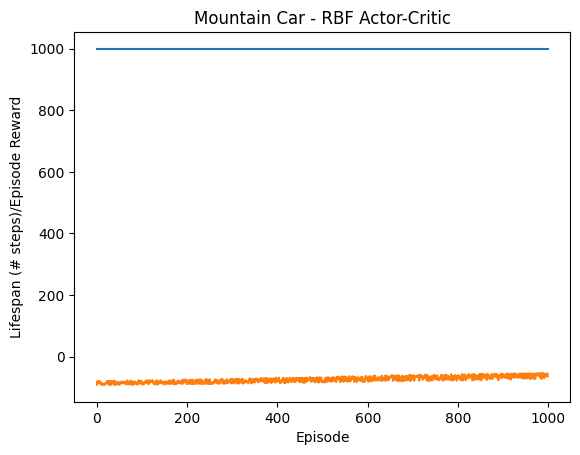

In [ ]:
plt.plot(range(len(info[0])), info[0])
plt.plot(range(len(info[0])), info[1])
plt.title("Mountain Car - RBF Actor-Critic")
plt.xlabel("Episode")
plt.ylabel("Lifespan (# steps)/Episode Reward")